In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(mclust)
library(cowplot)
library(tidyverse)
library(reshape)
library(SingleR)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(patchwork)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
      plot.title = element_text(size = 10),
    text = element_text(size = 10, colour = "black"),
    legend.text = element_text(size = 10),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: 'DT'


The following object is masked from 'package:SeuratObject':

    JS


The following object is masked from 'package:Seurat':

    JS



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


here() starts at /auto/brno2/home/vercanie/DIA

Package 'mclust' version 5.4.8
Type 'citation("mclust")' for citing this R package in publica

In [2]:
md  <- read_xlsx("data/dia_metadata2.xlsx")

In [4]:
cd8_subcluster  <- readRDS("data/processed/cd8_subcluster.rds")

In [3]:
md  %>% 

patient,rc,dat_nar,matched_dataset_manual,matched_group_manual,matched_dataset_propensity,matched_group_propensity,time_taken,age_taken,Patient_Time,...,HLA_DQB11,HLA_DQB12,HLA_DRA1,HLA_DRA2,HLA_DRB11,HLA_DRB12,HLA_E1,HLA_E2,HLA_F1,HLA_F2
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
101,1812230552,43457,NA,NA,NA,NA,T0,2.138261,101 T0,...,DQB1*02:01:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:02:02,DRB1*04:01:01,DRB1*03:01:01,E*01:01:01,E*01:01:01,F*01:01:01,F*01:01:01
102,1711110951,43050,NA,NA,NA,NA,T0,3.252567,102 T0,...,DQB1*03:02:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:01:01,DRB1*04:01:01,DRB1*04:01:01,E*01:01:01,E*01:03:02,F*01:01:01,F*01:01:01
103,1304191240,41383,yes,33,NA,NA,T0,7.816564,103 T0,...,DQB1*02:01:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:02:02,DRB1*04:04:01,DRB1*03:01:01,E*01:01:01,E*01:01:01,F*01:01:01,F*01:01:02
104,0408165087,38215,NA,NA,yes,33,T0,16.547570,104 T0,...,DQB1*02:01:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:02:02,DRB1*04:01:01,DRB1*03:01:01,E*01:01:01,E*01:01:01,F*01:01:01,F*01:01:01
105,1706101309,42896,NA,NA,NA,NA,T0,3.731691,105 T0,...,DQB1*02:01:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:02:02,DRB1*04:01:01,DRB1*03:01:01,E*01:01:01,E*01:03:02,F*01:03:01,F*01:01:01
106,1959271281,43735,NA,NA,NA,NA,T0,1.434634,106 T0,...,DQB1*05:02:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:01:01,DRB1*04:01:01,DRB1*16:01:01,E*01:01:01,E*01:03:02,F*01:01:01,F*01:01:01
107,1610250708,42668,NA,NA,NA,NA,T0,4.355921,107 T0,...,DQB1*02:01:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:02:02,DRB1*04:04:01,DRB1*03:01:01,E*01:01:01,E*01:01:01,F*01:01:01,F*01:01:02
108,1355270697,41421,yes,32,NA,NA,T0,7.786448,108 T0,...,DQB1*02:01:01,DQB1*03:02:01,DRA*01:01:01,DRA*01:01:01,DRB1*07:01:01,DRB1*03:01:01,E*01:01:01,E*01:01:01,F*01:03:01,F*01:03:01
109,1506260129,42181,NA,NA,NA,NA,T0,5.705681,109 T0,...,DQB1*02:01:01,DQB1*02:01:01,DRA*01:01:01,DRA*01:02:02,DRB1*03:01:01,DRB1*03:01:01,E*01:01:01,E*01:01:01,F*01:03:01,F*01:01:01


In [5]:
md  <-  md  %>% filter(patient %in% cd8_subcluster$Patient_ID)

In [7]:
md  %>% colnames

[1] "patient"                    "rc"                        
 [3] "dat_nar"                    "matched_dataset_manual"    
 [5] "matched_group_manual"       "matched_dataset_propensity"
 [7] "matched_group_propensity"   "time_taken"                
 [9] "age_taken"                  "Patient_Time"              
[11] "age_group"                  "sex"                       
[13] "dat_man"                    "age_man"                   
[15] "hba1c_man"                  "ph_man"                    
[17] "ahco3_man"                  "random_cpeptide_man"       
[19] "bh_man"                     "bh_man_sds"                
[21] "bw_man"                     "bw_man_sds"                
[23] "bmi_man"                    "bmi_man_sds"               
[25] "gad_man"                    "iaa_man"                   
[27] "ia2_man"                    "znt8_man"                  
[29] "date_taken_1"               "fasting_cpept_1"           
[31] "wbc"                        "lymph_abs"                 
[33] "mon_abs"                    "neutr_abs"                 
[35] "eoz_abs"                    "baz_abs"                   
[37] "lymph_perc"                 "mon_perc"                  
[39] "neutr_perc"                 "eoz_perc"                  
[41] "baz_perc"                   "tdd_1"                     
[43] "tdd_per_kg_1"               "fasting_cpept_T1"          
[45] "HLA_A1"                     "HLA_A2"                    
[47] "HLA_B1"                     "HLA_B2"                    
[49] "HLA_C1"                     "HLA_C2"                    
[51] "HLA_DMA1"                   "HLA_DMA2"                  
[53] "HLA_DMB1"                   "HLA_DMB2"                  
[55] "HLA_DOA1"                   "HLA_DOA2"                  
[57] "HLA_DPA11"                  "HLA_DPA12"                 
[59] "HLA_DPB11"                  "HLA_DPB12"                 
[61] "HLA_DQA11"                  "HLA_DQA12"                 
[63] "HLA_DQB11"                  "HLA_DQB12"                 
[65] "HLA_DRA1"                   "HLA_DRA2"                  
[67] "HLA_DRB11"                  "HLA_DRB12"                 
[69] "HLA_E1"                     "HLA_E2"                    
[71] "HLA_F1"                     "HLA_F2"

In [22]:
options(repr.plot.width = 20)
md  <- md %>% 
mutate(yy = 1)  %>% 
mutate(name = paste(substr(patient,1,1), "aa", age_group, sex, Patient_Time))  %>% 
mutate(name = str_replace_all(name, "3 aa", replacement = "11 "))

In [23]:
order(levels(factor(md$name)))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
[76] 76 77 78 79

Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."


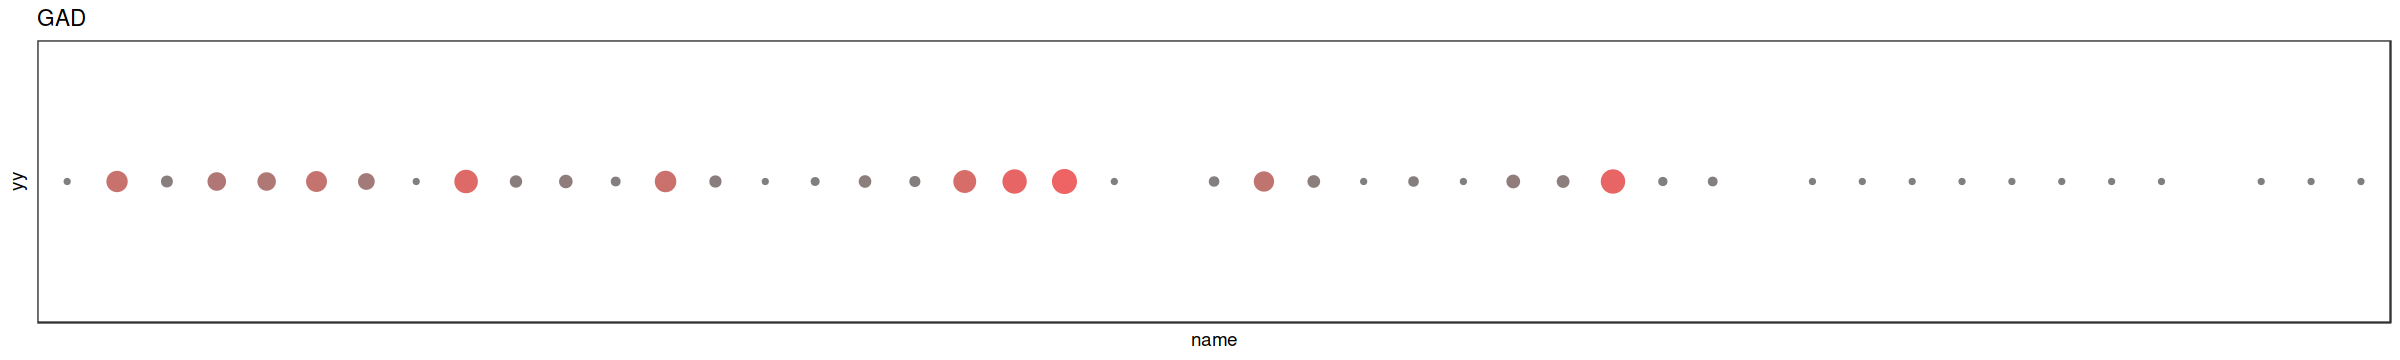

In [89]:
options(repr.plot.width = 20, repr.plot.height = 3)

md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(size = gad_man, colour = gad_man)) + 
scale_color_gradient(low = "grey50", high = "indianred2") +
  theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("GAD") + NoLegend()
ggsave("gad.svg", width = 23, height = 3, units = "cm")

Warning message:
"Removed 11 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 11 rows containing missing values (`geom_point()`)."


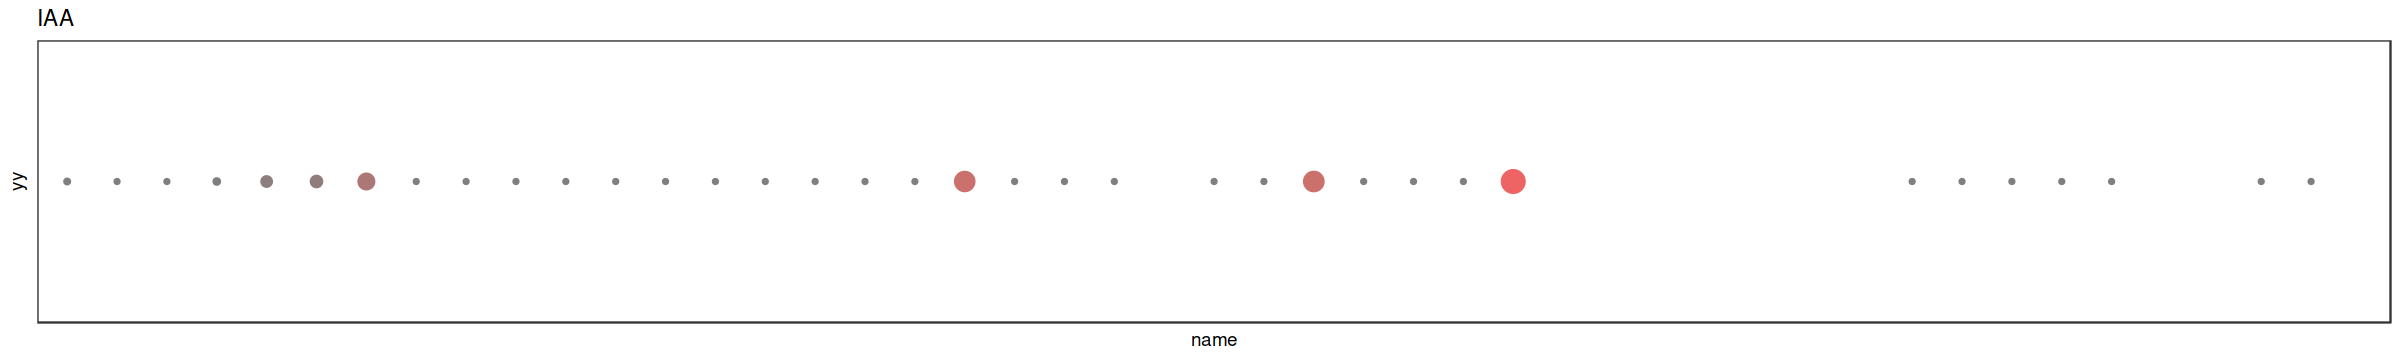

In [87]:
options(repr.plot.width = 20, repr.plot.height = 3)

md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(size = iaa_man, colour = iaa_man)) + 
scale_color_gradient(low = "grey50", high = "indianred2") +
   theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("IAA") + NoLegend()
ggsave("iaa.svg", width = 23, height = 3, units = "cm")

Warning message:
"Removed 7 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 7 rows containing missing values (`geom_point()`)."


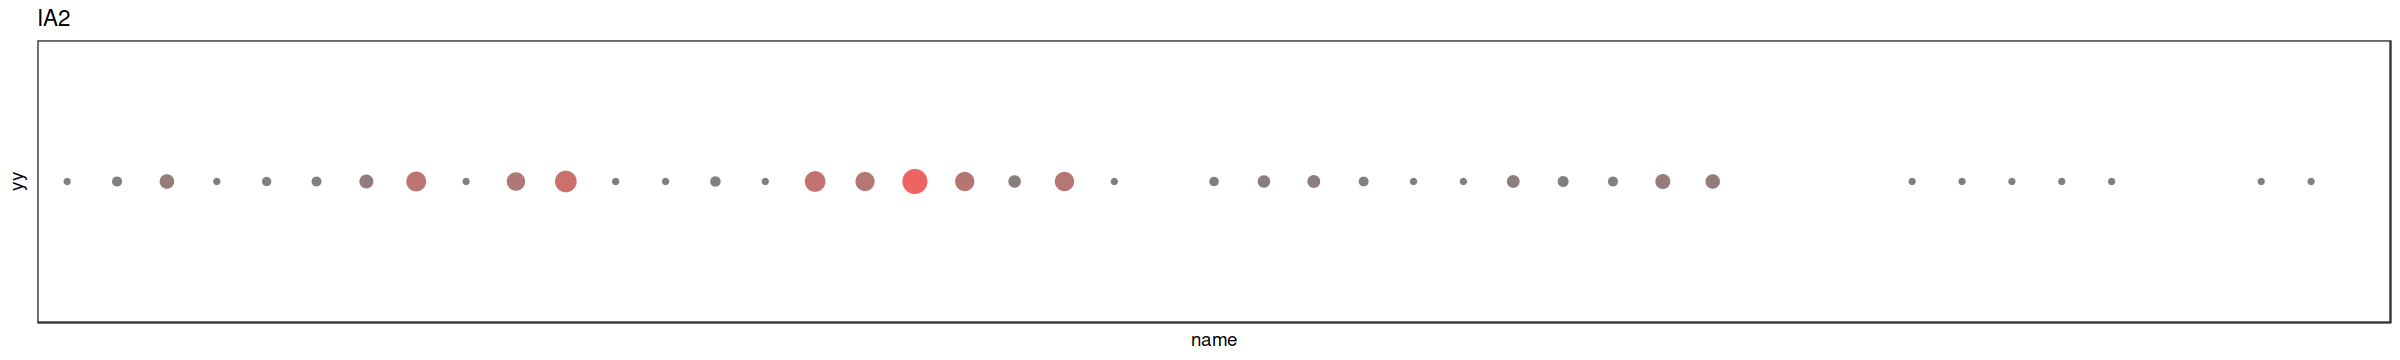

In [86]:
md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(size = ia2_man, colour = ia2_man)) + 
scale_color_gradient(low = "grey50", high = "indianred2") +
   theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("IA2") + NoLegend()
ggsave("ia2.svg", width = 23, height = 3, units = "cm")

Warning message:
"Removed 22 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 22 rows containing missing values (`geom_point()`)."


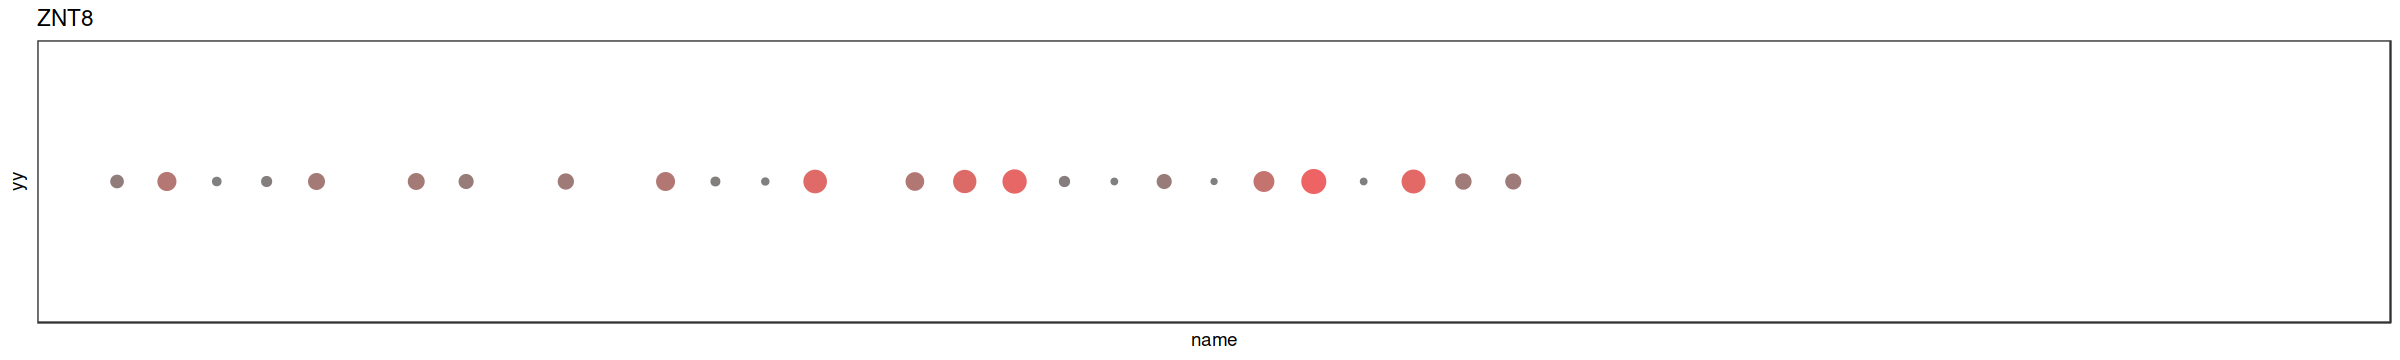

In [85]:
md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(size = znt8_man, colour = znt8_man)) + 
scale_color_gradient(low = "grey50", high = "indianred2") +
  theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("ZNT8") + NoLegend()
ggsave("znt8.svg", width = 23, height = 3, units = "cm")

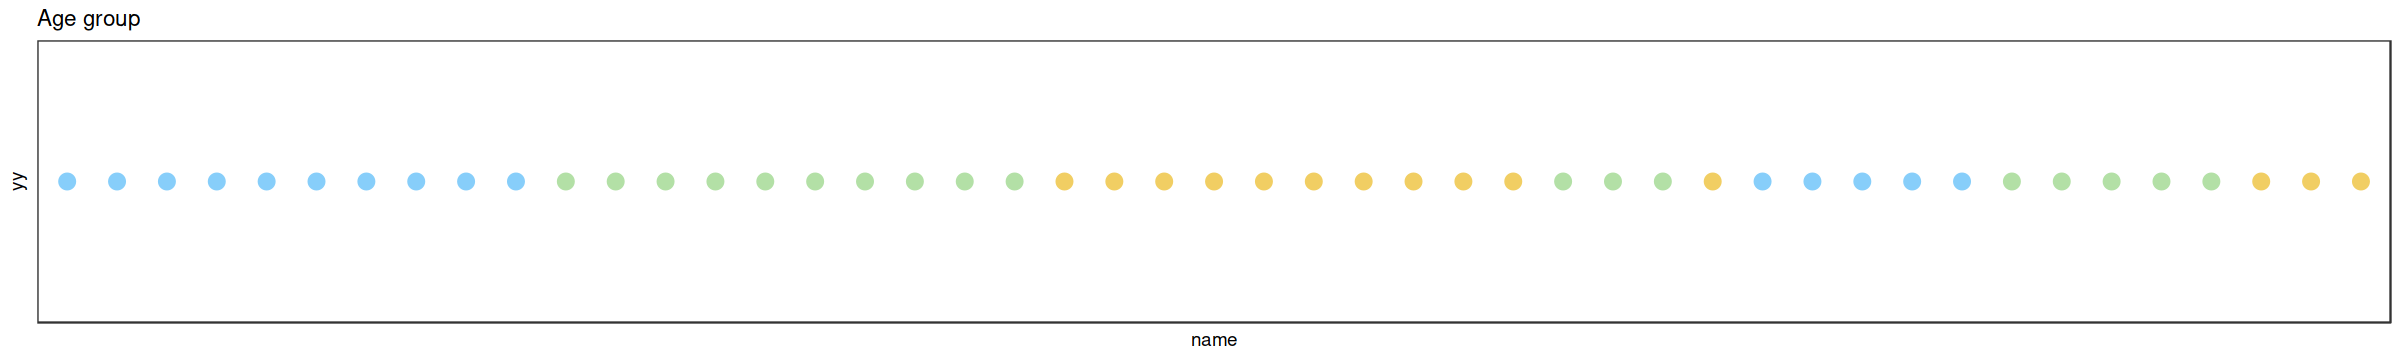

In [84]:
md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(colour = as.factor(age_group)), size = 4) + 
scale_color_manual(values = c("lightskyblue","#b3e0a6", "#f1ce63")) +
  theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("Age group") + NoLegend()
ggsave("age.svg", width = 23, height = 3, units = "cm")

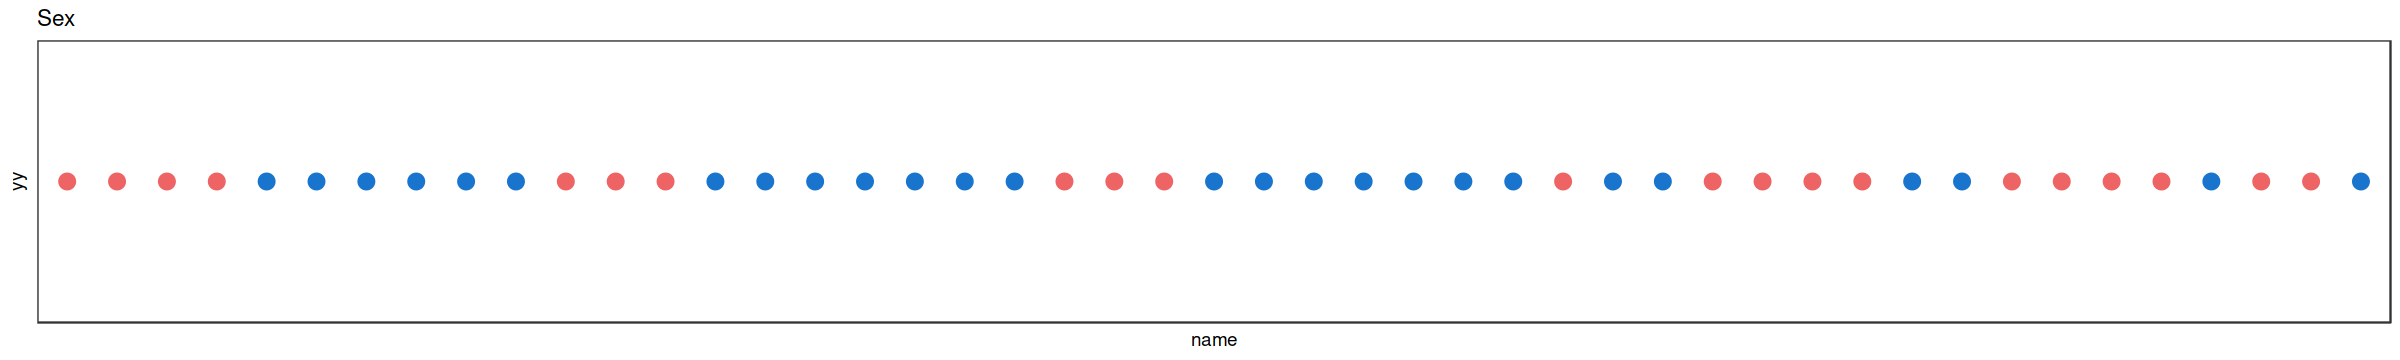

In [80]:
md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(colour = as.factor(sex)), size = 4) + 
scale_color_manual(values = c("indianred2","dodgerblue3")) +
 theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("Sex") + NoLegend()
ggsave("sex.svg", width = 23, height = 3, units = "cm")

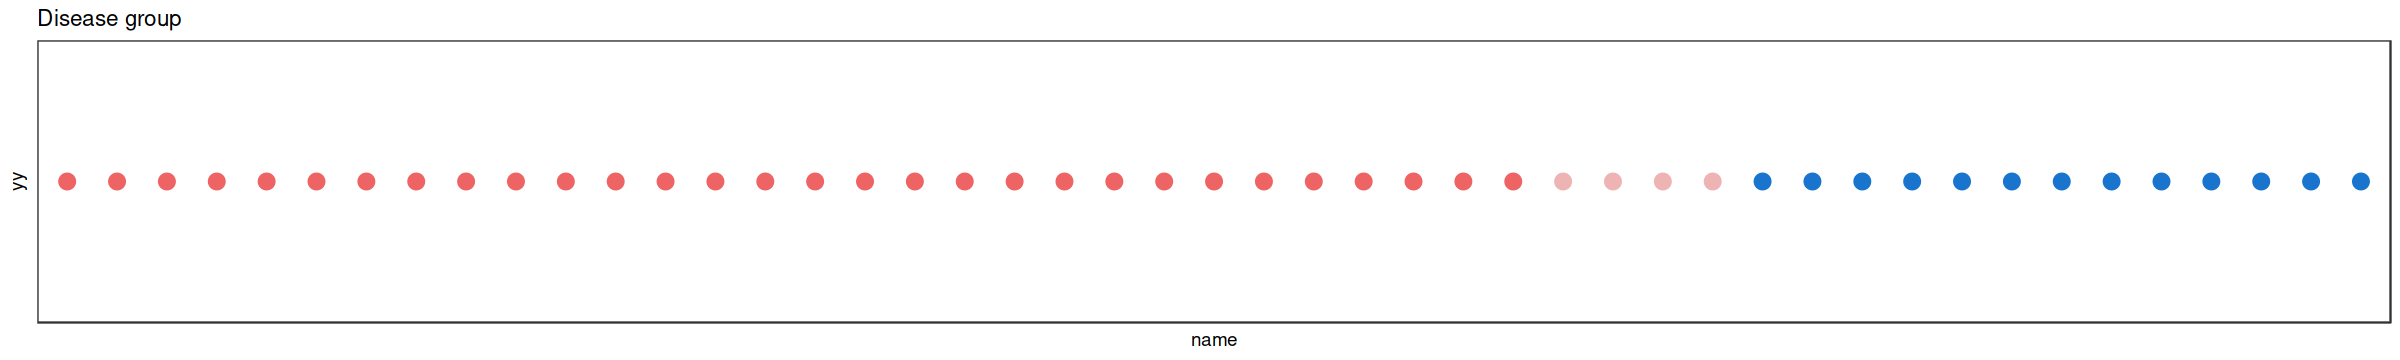

In [79]:
md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(colour = as.factor(substr(patient,1,1))), size = 4) + 
scale_color_manual(values = c("indianred2","dodgerblue3","rosybrown2")) +
  theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("Disease group") + NoLegend()
ggsave("disease.svg", width = 23, height = 3, units = "cm")

In [90]:
colnames(md)

[1] "patient"                    "rc"                        
 [3] "dat_nar"                    "matched_dataset_manual"    
 [5] "matched_group_manual"       "matched_dataset_propensity"
 [7] "matched_group_propensity"   "time_taken"                
 [9] "age_taken"                  "Patient_Time"              
[11] "age_group"                  "sex"                       
[13] "dat_man"                    "age_man"                   
[15] "hba1c_man"                  "ph_man"                    
[17] "ahco3_man"                  "random_cpeptide_man"       
[19] "bh_man"                     "bh_man_sds"                
[21] "bw_man"                     "bw_man_sds"                
[23] "bmi_man"                    "bmi_man_sds"               
[25] "gad_man"                    "iaa_man"                   
[27] "ia2_man"                    "znt8_man"                  
[29] "date_taken_1"               "fasting_cpept_1"           
[31] "wbc"                        "lymph_abs"                 
[33] "mon_abs"                    "neutr_abs"                 
[35] "eoz_abs"                    "baz_abs"                   
[37] "lymph_perc"                 "mon_perc"                  
[39] "neutr_perc"                 "eoz_perc"                  
[41] "baz_perc"                   "tdd_1"                     
[43] "tdd_per_kg_1"               "fasting_cpept_T1"          
[45] "HLA_A1"                     "HLA_A2"                    
[47] "HLA_B1"                     "HLA_B2"                    
[49] "HLA_C1"                     "HLA_C2"                    
[51] "HLA_DMA1"                   "HLA_DMA2"                  
[53] "HLA_DMB1"                   "HLA_DMB2"                  
[55] "HLA_DOA1"                   "HLA_DOA2"                  
[57] "HLA_DPA11"                  "HLA_DPA12"                 
[59] "HLA_DPB11"                  "HLA_DPB12"                 
[61] "HLA_DQA11"                  "HLA_DQA12"                 
[63] "HLA_DQB11"                  "HLA_DQB12"                 
[65] "HLA_DRA1"                   "HLA_DRA2"                  
[67] "HLA_DRB11"                  "HLA_DRB12"                 
[69] "HLA_E1"                     "HLA_E2"                    
[71] "HLA_F1"                     "HLA_F2"                    
[73] "yy"                         "name"

In [100]:
md  <- md  %>% mutate(dq2 = ifelse((HLA_DQA11 == "DQA1*05:01:01" | HLA_DQA12 == "DQA1*05:01:01") &
                                   (HLA_DQB11 == "DQB1*02:01:01" | HLA_DQB12 == "DQB1*02:01:01"),"DQ2",
                                   "Other"),
                      dq8 = ifelse((HLA_DQA11 == "DQA1*03:01:01" | HLA_DQA12 == "DQA1*03:01:01") &
                                   (HLA_DQB11 == "DQB1*03:02:01" | HLA_DQB12 == "DQB1*03:02:01"),"DQ8",
                                   "Other"))  %>% mutate(
                      dq2_8 = ifelse(dq2 == "DQ2" & dq8 == "DQ8","DQ2_8",
                                     ifelse(dq2 == "DQ2","DQ2", ifelse(dq8 == "DQ8","DQ8","Other"))))
                     

In [101]:
md  %>% dplyr::select(patient, dq2, dq8, dq2_8)

patient,dq2,dq8,dq2_8
<dbl>,<chr>,<chr>,<chr>
101,DQ2,DQ8,DQ2_8
102,Other,DQ8,DQ8
103,DQ2,DQ8,DQ2_8
104,DQ2,DQ8,DQ2_8
105,DQ2,DQ8,DQ2_8
106,Other,DQ8,DQ8
107,DQ2,DQ8,DQ2_8
108,DQ2,Other,DQ2
109,DQ2,Other,DQ2


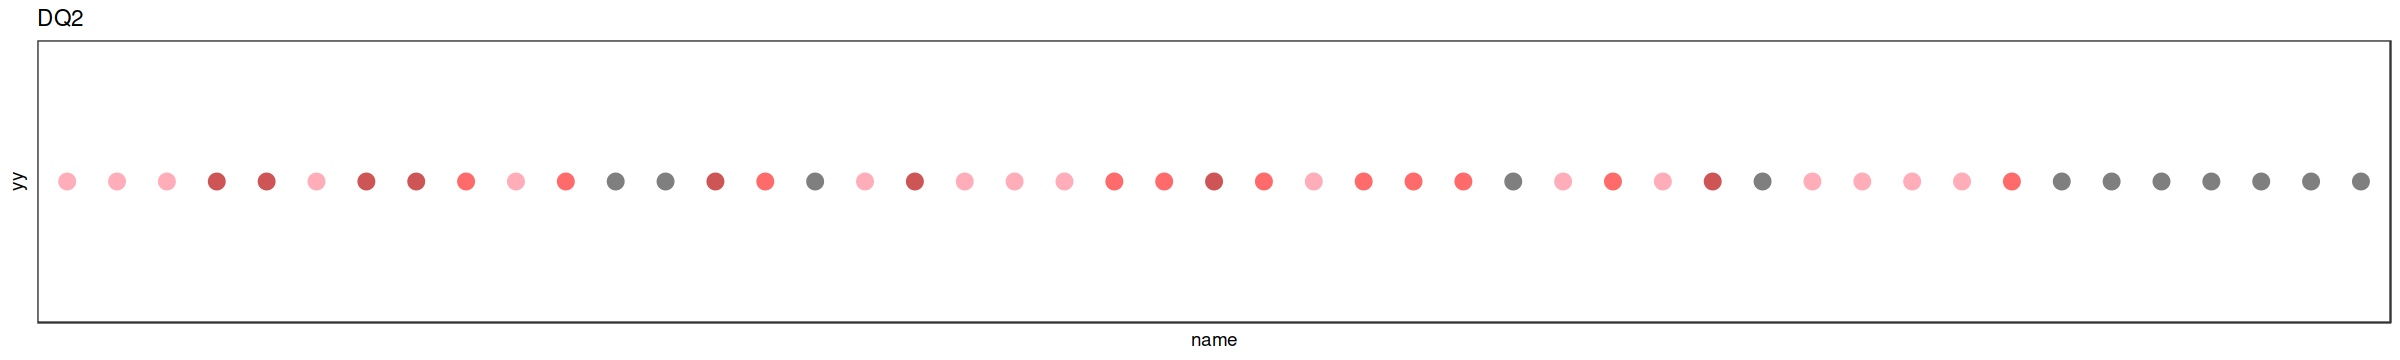

In [108]:
md  %>% filter(time_taken == "T0")  %>% 
ggplot(aes(x = name, y = yy)) + geom_point(aes(colour = as.factor(dq2_8)), size = 4) + 
scale_color_manual(values = c("#ff6a6aff","#cd5555ff","#ffaeb9ff","grey50")) +
  theme_bw() + theme(axis.text.x = element_blank(),
                    axis.text.y = element_blank(),
                    axis.ticks = element_blank(),
                    panel.grid = element_blank(),
                    ) + ggtitle("DQ2") + NoLegend()
ggsave("dq2.svg", width = 23, height = 3, units = "cm")